In [72]:
import pandas as pd 

data = pd.read_csv('data.csv')

data.loc[data['malade'] == False, 'nom_maladie'] = 'healthy'

data.head()
print(len(data.espece.unique()))

14


### Création d'un échantillon 

In [2]:
class_counts = data['nom_maladie'].value_counts()
species_counts = data['espece'].value_counts()
sick_counts = data['malade'].value_counts()

# Calcul du nombre d'images à prélever
num_images_per_class = round(1500 / len(class_counts))
num_images_per_species = round(1500 / len(species_counts))
num_images_sick = round(2000 / len(sick_counts))

# Création des échantillons équilibrés
sample = pd.DataFrame()
for class_name, count in class_counts.items():
    samples = data[data['nom_maladie'] == class_name].sample(min(count, num_images_per_class), random_state=42)
    sample = sample.append(samples)

for species_name, count in species_counts.items():
    samples = data[data['espece'] == species_name].sample(min(count, num_images_per_species), random_state=42)
    sample = sample.append(samples)

for sick_value, count in sick_counts.items():
    samples = data[data['malade'] == sick_value].sample(min(count, num_images_sick), random_state=42)
    sample = sample.append(samples)

# Mélange aléatoire
sample = sample.sample(frac=1, random_state=42).reset_index(drop=True)

C:\Users\aissa\AppData\Local\Temp\ipykernel_27288\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_27288\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_27288\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_27288\3821067970.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = sample.append(samples)
C:\Users\aissa\AppData\Local\Temp\ipykernel_27288\3821067970

In [3]:
sample

,img_path,espece,malade,nom_maladie
0,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Grape,True,Esca_(Black_Measles)
1,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Tomato,True,Early_blight
2,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
3,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Strawberry,True,Leaf_scorch
4,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Soybean,False,healthy
...,...,...,...,...
4984,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,False,healthy
4985,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Apple,True,Apple_scab
4986,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Potato,True,Late_blight
4987,C:\Users\aissa\Desktop\Projet\Exploration\new_...,Tomato,True,Tomato_Yellow_Leaf_Curl_Virus


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [5]:
# Paramètres du modèle

input_shape = (256, 256, 3)  
num_classes = len(sample.espece.unique())

### Prétraitement des données

In [6]:
# Normalisation des pixels

data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [7]:
train_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="espece",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

Found 3992 validated image filenames belonging to 14 classes.


In [8]:
validation_generator = data_generator.flow_from_dataframe(
    dataframe=sample,
    x_col="img_path",
    y_col="espece",
    target_size=input_shape[:2],
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

Found 997 validated image filenames belonging to 14 classes.


### Modélisation sur l'échantillon

In [9]:
# CNN

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [10]:
# Compilation du modèle

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Entraînement du modèle

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=8,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/8
62/62 [==============================] - 190s 3s/step - loss: 2.8219 - accuracy: 0.3068 - val_loss: 1.8591 - val_accuracy: 0.5396
Epoch 2/8
62/62 [==============================] - 177s 3s/step - loss: 1.6389 - accuracy: 0.6029 - val_loss: 1.3602 - val_accuracy: 0.6875
Epoch 3/8
62/62 [==============================] - 184s 3s/step - loss: 1.2246 - accuracy: 0.7240 - val_loss: 1.2001 - val_accuracy: 0.7104
Epoch 4/8
62/62 [==============================] - 190s 3s/step - loss: 1.0576 - accuracy: 0.7757 - val_loss: 1.1772 - val_accuracy: 0.7292
Epoch 5/8
62/62 [==============================] - 173s 3s/step - loss: 0.9092 - accuracy: 0.8246 - val_loss: 1.2505 - val_accuracy: 0.7167
Epoch 6/8
62/62 [==============================] - 174s 3s/step - loss: 0.8113 - accuracy: 0.8566 - val_loss: 1.1266 - val_accuracy: 0.7635
Epoch 7/8
62/62 [==============================] - 172s 3s/step - loss: 0.7379 - accuracy: 0.8765 - val_loss: 1.0878 - val_accuracy: 0.7552
Epoch 8/8
62/62 [===

### Généralisation à l'ensemble du dataset

In [18]:
pip install --upgrade tensorflow

  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plaidml-keras 0.7.0 requires keras==2.2.4, but you have keras 2.12.0 which is incompatible.


In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint

import os

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

### Division du jeu de données en 10 dataframes équilibrés

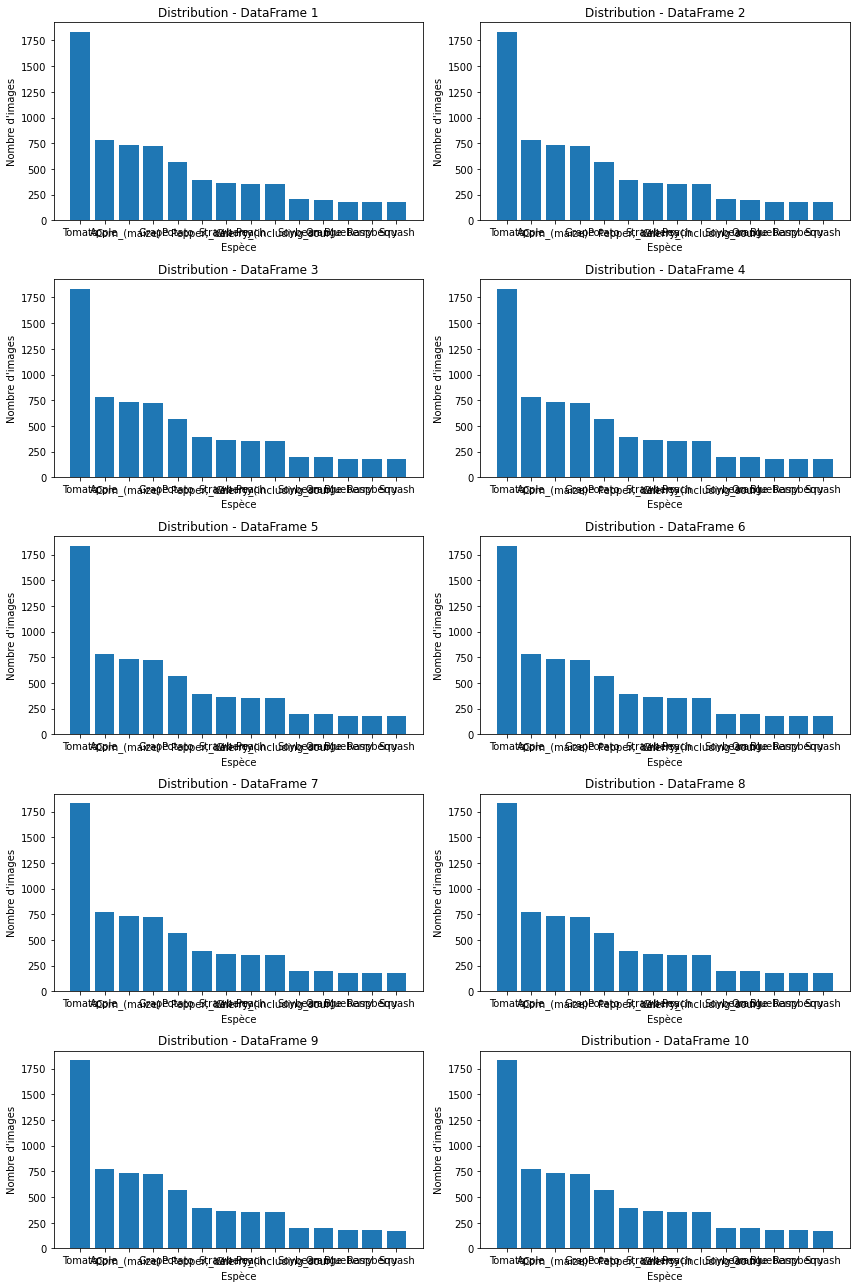

In [20]:
from sklearn.model_selection import StratifiedShuffleSplit

X = data.drop(['espece', 'malade', 'nom_maladie'], axis=1)
y = data['espece']

dfs = []
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.9)
for train_index, _ in sss.split(X, y):
    df = pd.concat([X.iloc[train_index].reset_index(drop=True), y.iloc[train_index].reset_index(drop=True)], axis=1)
    dfs.append(df)

fig, axs = plt.subplots(5, 2, figsize=(12, 18))

for i, df in enumerate(dfs):
    value_counts = df['espece'].value_counts()
    
    row = i // 2
    col = i % 2
    
    axs[row, col].bar(value_counts.index, value_counts.values)
    axs[row, col].set_title(f"Distribution - DataFrame {i+1}")
    axs[row, col].set_xlabel("Espèce")
    axs[row, col].set_ylabel("Nombre d'images")

plt.tight_layout()
plt.show()

### Prétraitement des données 

In [21]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generators = []
validation_generators = []

for i in range(10):
    data_i = dfs[i]  
    
    train_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="espece",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='training'
    )
    train_generators.append(train_generator)
    
    validation_generator = data_generator.flow_from_dataframe(
        dataframe=data_i,
        x_col="img_path",
        y_col="espece",
        target_size=input_shape[:2],
        batch_size=64,
        class_mode='categorical',
        subset='validation'
    )
    validation_generators.append(validation_generator)

Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 5624 validated image filenames belonging to 14 classes.
Found 1405 validated image filenames belonging to 14 classes.
Found 56

### Modélisation 

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_callback = ModelCheckpoint(
    'cnn_id_espece.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

# Boucle pour entraîner le modèle pour chaque data_i

for i in range(10):
    train_generator_i = train_generators[i]
    validation_generator_i = validation_generators[i]

    print(f"Entraînement du modèle pour data_{i+1} :")

    history = model.fit(
        train_generator_i,
        steps_per_epoch=train_generator_i.samples // train_generator_i.batch_size,
        epochs=8,
        validation_data=validation_generator_i,
        validation_steps=validation_generator_i.samples // validation_generator_i.batch_size,
        callbacks=[checkpoint_callback]
    )

    print(f"Fin de l'entraînement du modèle pour data_{i+1}.")
    print()

Entraînement du modèle pour data_1 :
Epoch 1/8
87/87 [==============================] - ETA: 0s - loss: 2.5596 - accuracy: 0.4135
Epoch 1: val_loss improved from inf to 1.77893, saving model to cnn_id_espece.h5
87/87 [==============================] - 251s 3s/step - loss: 2.5596 - accuracy: 0.4135 - val_loss: 1.7789 - val_accuracy: 0.5662
Epoch 2/8
87/87 [==============================] - ETA: 0s - loss: 1.5475 - accuracy: 0.6297
Epoch 2: val_loss improved from 1.77893 to 1.39258, saving model to cnn_id_espece.h5
87/87 [==============================] - 242s 3s/step - loss: 1.5475 - accuracy: 0.6297 - val_loss: 1.3926 - val_accuracy: 0.6689
Epoch 3/8
87/87 [==============================] - ETA: 0s - loss: 1.2506 - accuracy: 0.7119
Epoch 3: val_loss improved from 1.39258 to 1.25441, saving model to cnn_id_espece.h5
87/87 [==============================] - 242s 3s/step - loss: 1.2506 - accuracy: 0.7119 - val_loss: 1.2544 - val_accuracy: 0.7143
Epoch 4/8
87/87 [==========================

Epoch 5/8
87/87 [==============================] - ETA: 0s - loss: 0.3813 - accuracy: 0.9755
Epoch 5: val_loss did not improve from 0.74866
87/87 [==============================] - 243s 3s/step - loss: 0.3813 - accuracy: 0.9755 - val_loss: 0.8897 - val_accuracy: 0.8296
Epoch 6/8
87/87 [==============================] - ETA: 0s - loss: 0.3997 - accuracy: 0.9691
Epoch 6: val_loss did not improve from 0.74866
87/87 [==============================] - 247s 3s/step - loss: 0.3997 - accuracy: 0.9691 - val_loss: 0.7746 - val_accuracy: 0.8676
Epoch 7/8
87/87 [==============================] - ETA: 0s - loss: 0.4284 - accuracy: 0.9662
Epoch 7: val_loss did not improve from 0.74866
87/87 [==============================] - 256s 3s/step - loss: 0.4284 - accuracy: 0.9662 - val_loss: 0.9455 - val_accuracy: 0.8162
Epoch 8/8
87/87 [==============================] - ETA: 0s - loss: 0.4235 - accuracy: 0.9716
Epoch 8: val_loss did not improve from 0.74866
87/87 [==============================] - 503s 6s/s

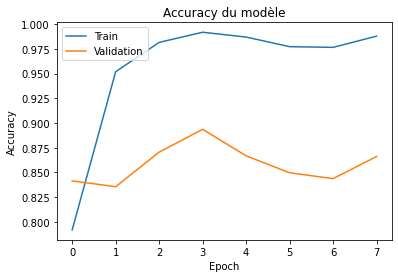

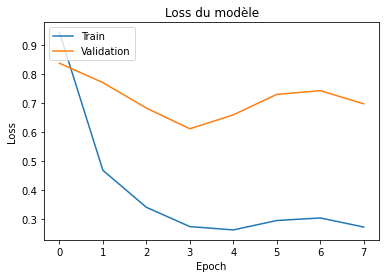

In [23]:
# Visualisation de l'accuracy du train et de la validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy du modèle')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Visualisation de la loss du train et de la validation
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss du modèle')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test du modèle sur les données de validation

In [74]:
data_test = pd.read_csv('data_test.csv')

data_test.head()
print(len(data_test.espece.unique()))

14


In [25]:
# Prétraitement des images

image_size = (256, 256)
batch_size = 64

datagen = ImageDataGenerator(rescale=1.0/255.0)

data_generator = datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col='img_path',
    y_col='espece',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical', 
    shuffle=False  
)


Found 17572 validated image filenames belonging to 14 classes.


In [27]:
# Chargement du modèle 

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.load_weights('cnn_id_espece.h5')

# Compilation 

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Sauvegarde du modèle

model.save('model_cnn_id_espece.h5')

In [ ]:
# Prédictions

predictions = model.predict(data_generator)

In [41]:
import numpy as np

predicted_labels = np.argmax(predictions, axis=1)

In [42]:
true_labels = data_generator.classes
class_labels = data_generator.class_indices

Accuracy : 87.75%


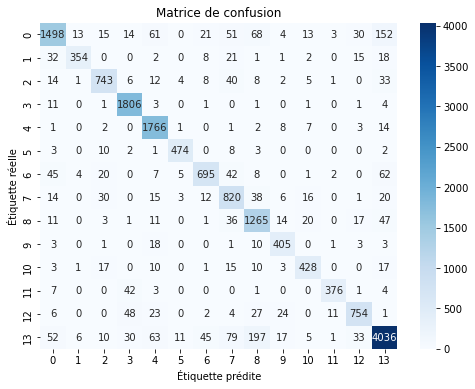

In [43]:
# Évaluation

from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy : {:.2f}%".format(accuracy * 100))

import seaborn as sns

confusion = confusion_matrix(true_labels, predicted_labels)

class_labels = np.unique(true_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matrice de confusion")
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.show()